In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, TensorDataset

%matplotlib inline

In [2]:
np.random.seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [6]:
data_dir = 'dataset/mobiact_preprocessed/'

In [9]:
train = pd.read_csv(data_dir + 'train.csv')
valid = pd.read_csv(data_dir + 'valid.csv')
test = pd.read_csv(data_dir + 'test.csv')

In [10]:
encoder = LabelEncoder()
encoder.fit(activity_info['Label'])

train_encoded = encoder.transform(train['label'])
train['label_encoded'] = train_encoded

valid_encoded = encoder.transform(valid['label'])
valid['label_encoded'] = valid_encoded

test_encoded = encoder.transform(test['label'])
test['label_encoded'] = test_encoded

In [11]:
train_obs_scaler = StandardScaler()
train_tar_scaler = StandardScaler()

test_obs_scaler = StandardScaler()
test_tar_scaler = StandardScaler()

columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z','label', 'person_id']

obs_train = train[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
obs_train = train_obs_scaler.fit_transform(obs_train)
tar_train = np.asarray(train['label_encoded'])
tar_train = train_tar_scaler.fit_transform(tar_train.reshape(-1, 1))

obs_train = pd.DataFrame(obs_train)
tar_train = pd.DataFrame(tar_train)
transformed_train = pd.concat([obs_train, tar_train], axis=1)
transformed_train['per-id'] = train['person_id'].values
transformed_train.columns = columns
# transformed_train.head()

obs_valid = valid[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
obs_valid = train_obs_scaler.fit_transform(obs_valid)
tar_valid = np.asarray(valid['label_encoded'])
tar_valid = train_tar_scaler.fit_transform(tar_valid.reshape(-1, 1))

obs_valid = pd.DataFrame(obs_valid)
tar_valid = pd.DataFrame(tar_valid)
transformed_valid = pd.concat([obs_valid, tar_valid], axis=1)
transformed_valid['per-id'] = valid['person_id'].values
transformed_valid.columns = columns
# transformed_valid.head()

obs_test = test[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
obs_test = test_obs_scaler.fit_transform(obs_test)
tar_test = np.asarray(test['label_encoded'])
tar_test = test_tar_scaler.fit_transform(tar_test.reshape(-1, 1))

obs_test = pd.DataFrame(obs_test)
tar_test = pd.DataFrame(tar_test)
transformed_test = pd.concat([obs_test, tar_test], axis=1)
transformed_test['per-id'] = test['person_id'].values
transformed_test.columns = columns
transformed_test.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label,person_id
0,0.253991,-0.471178,2.004895,0.012858,0.017883,-0.008033,-0.167311,61
1,0.253991,-0.471765,2.004364,0.006562,0.011549,-0.017275,-0.167311,61
2,0.253134,-0.471958,2.002759,0.011850,0.009701,-0.008033,-0.167311,61
3,0.251858,-0.471958,2.000628,0.005806,0.011812,-0.003192,-0.167311,61
4,0.250436,-0.471958,1.998253,0.002281,0.001783,-0.025197,-0.167311,61


# Data processing

In [12]:
def dataProcessing(data):
    X_data, y_data = list(), list()
    for i in range(43, len(data) - 44):
        acc_x = data['acc_x'][i-43: i]
        acc_y = data['acc_y'][i-43: i]
        acc_z = data['acc_z'][i-43: i]
        gyro_x = data['gyro_x'][i-43: i]
        gyro_y = data['gyro_y'][i-43: i]
        gyro_z = data['gyro_z'][i-43: i]
        X_data.append([acc_x.values, acc_y.values, acc_z.values, gyro_x.values, gyro_y.values, gyro_z.values])
        
        outcome = data['label'][i: i+44]
        y_data.append([outcome.values])
    return X_data, y_data

In [ ]:
X_train, y_train = dataProcessing(transformed_train)
X_valid, y_valid = dataProcessing(transformed_valid)
X_test, y_test = dataProcessing(transformed_test)

In [ ]:
batch_size = 128

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

valid_data = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

# Model

In [11]:
from model.singleLSTM import singleLSTM
from model.stackedLSTM import stackedLSTM
from model.CNN import CNN

In [12]:
def choose_model(model_type):
    if model_type == 'singleLSTM':
        model = singleLSTM(3, 320, 32).cuda()
        save_path = 'results/singleLSTM/'
        save_file_name = save_path + 'SingleLSTMNotch.pth'
    elif model_type == 'stackedLSTM':
        model = stackedLSTM(3, 320, 32).cuda()
        save_path = 'results/stackedLSTM/'
        save_file_name = save_path + 'StackedLSTMNotch.pth'
    elif model_type == 'CNN':
        model = CNN(3, [8, 16, 64], 32).cuda()
        save_path = 'results/CNN/'
        save_file_name = save_path + 'CNNNotch.pth'
    return model, save_path, save_file_name

In [31]:
model_type = 'singleLSTM'
model, save_path, save_file_name = choose_model(model_type)
print(model)

singleLSTM(
  (lstm): LSTM(3, 320, batch_first=True)
  (bn): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=320, out_features=32, bias=True)
)


In [32]:
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       mode='min',
                                                       factor=0.2
                                                    )
criterion = nn.MSELoss().cuda()
patience = 5
n_epochs = 300

In [33]:
# example

with torch.no_grad():
    dataiter = iter(train_loader)
    X, y = dataiter.next()
    
    ex_model = model
    if model_type != 'CNN':
        X = X.view(-1, 32, 3)
    print('X size', X.shape)
    print('y size', y.shape)
    output = ex_model(X.cuda())
    print(output.shape)

X size torch.Size([64, 32, 3])
y size torch.Size([64, 1, 32])
torch.Size([64, 32])


In [16]:
def fit(model, batch_size, n_epochs, save_file_name):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    best_loss = 9999999999
    patience = 0
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            if model_type != 'CNN':
                data, target = data.view(-1, 32, 3).cuda(), target.cuda()
            else:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            if model_type != 'CNN':
                loss = criterion(output, target.squeeze())
            else:
                loss = criterion(output.squeeze(), target.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            if model_type != 'CNN':
                data, target = data.view(-1, 32, 3).cuda(), target.cuda()
            else:
                data, target = data.cuda(), target.cuda()
            output = model(data.cuda())
            if model_type != 'CNN':
                loss = criterion(output, target.squeeze())
            else:
                loss = criterion(output.squeeze(), target.squeeze())
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
            
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        train_losses = []
        valid_losses = []
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = 0
            torch.save(model.state_dict(), save_file_name)
            print('Saving Model')
        else:
            patience += 1
            print('Patience for ', patience)
        if patience == 10:
            break

    model.load_state_dict(torch.load(save_file_name))

    return  model, avg_train_losses, avg_valid_losses

In [17]:
model, train_loss, valid_loss = fit(model, batch_size, n_epochs, save_file_name)

[  1/300] train_loss: 0.07887 valid_loss: 0.10687
Saving Model
[  2/300] train_loss: 0.07350 valid_loss: 0.09617
Saving Model
[  3/300] train_loss: 0.07252 valid_loss: 0.09664
Patience for  1
[  4/300] train_loss: 0.07209 valid_loss: 0.09848
Patience for  2
[  5/300] train_loss: 0.07180 valid_loss: 0.10029
Patience for  3
[  6/300] train_loss: 0.07157 valid_loss: 0.10182
Patience for  4
[  7/300] train_loss: 0.07136 valid_loss: 0.10287
Patience for  5
[  8/300] train_loss: 0.07116 valid_loss: 0.10313
Patience for  6
[  9/300] train_loss: 0.07097 valid_loss: 0.10228
Patience for  7
[ 10/300] train_loss: 0.07079 valid_loss: 0.10016
Patience for  8
[ 11/300] train_loss: 0.07058 valid_loss: 0.09762
Patience for  9
[ 12/300] train_loss: 0.07038 valid_loss: 0.09502
Saving Model
[ 13/300] train_loss: 0.07017 valid_loss: 0.09250
Saving Model
[ 14/300] train_loss: 0.06996 valid_loss: 0.09029
Saving Model
[ 15/300] train_loss: 0.06973 valid_loss: 0.08855
Saving Model
[ 16/300] train_loss: 0.0694

In [34]:
def evaluate_model(model, test_loader):
    test_loss = 0.0
    y_test = []
    y_hat = []
    model.eval()
    for data,target in test_loader:
        if model_type != 'CNN':
            data, target = data.view(-1, 32, 3).cuda(), target.cuda()
        else:
            data, target = data.cuda(), target.cuda()   
        output = model(data.cuda())
        loss = criterion(output.squeeze(), target.squeeze())
        test_loss += loss.item()
        y_test += list(target.squeeze().detach().cpu().numpy())
        y_hat += list(output.squeeze().detach().cpu().numpy())
        
    return test_loss/len(test_loader), y_test, y_hat

In [35]:
model.load_state_dict(torch.load(save_path + 'SingleLSTMNotch.pth'))

<All keys matched successfully>

In [36]:
test_loss, y_target, y_hat = evaluate_model(model, test_loader)

In [37]:
labels = test_tar_scaler.inverse_transform(y_target)
predicted = test_tar_scaler.inverse_transform(y_hat)

In [38]:
len(y_target), len(y_hat)

(338624, 338624)

In [39]:
corrected_labels = []
for i in range(len(labels)):
    if labels[i] != 1.0:
        corrected_labels.append(0.0)
    else:
        corrected_labels.append(1.0)

In [40]:
from collections import Counter
cnt_y_hat = Counter(predicted)

thres = np.array(list(cnt_y_hat.keys())).mean()
corrected_predicted = []
for i in range(len(predicted)):
    if predicted[i] < thres:
        corrected_predicted.append(0.0)
    else:
        corrected_predicted.append(1.0)

In [41]:
print(confusion_matrix(corrected_labels, corrected_predicted))
print()
acc = accuracy_score(corrected_labels, corrected_predicted)
f1 = f1_score(corrected_labels, corrected_predicted)
recall = recall_score(corrected_labels, corrected_predicted)
precision = precision_score(corrected_labels, corrected_predicted)

print('recall score is ', recall)
print('precision score is ', precision)
print('f1 score is ', f1)
print('accuracy score is ', acc)

[[165064 140216]
 [ 14667  18677]]

recall score is  0.5601307581573897
precision score is  0.11754451108607679
f1 score is  0.19431222917544488
accuracy score is  0.5426106832356833


In [25]:
result = pd.DataFrame([acc, precision, recall, f1]).T
result.columns = ['Accuracy', 'Precision', 'Recall', 'F1']
result.to_csv(save_path + 'stackedLSTMNotch.csv')

In [43]:
labels_32, predicted_32 = list(), list()
for i in range(len(labels)):
    if i % 32 == 0:
        labels_32.append(labels[i])
for i in range(len(predicted)):
    if i % 32 == 0:
        predicted_32.append(predicted[i])

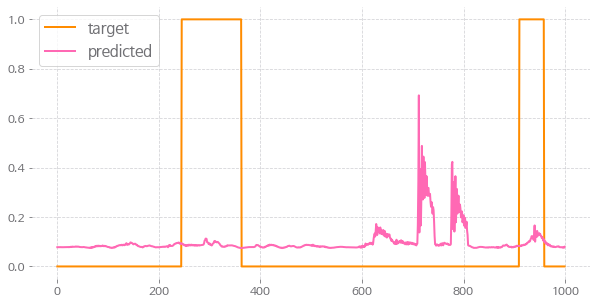

<Figure size 432x288 with 0 Axes>

In [44]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(labels_32[600:1600], label='target', color='darkorange')
plt.plot(predicted_32[600:1600], label='predicted', color='hotpink')
plt.legend(loc='upper left', fontsize=15)
plt.show()
plt.savefig(save_path + 'singleLSTMNotch.png')